# K-OLLI
Kalman-based online low-rank last-layer inference

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import jax
import keras
import numpy as np
import pandas as pd
import flax.linen as nn
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
from functools import partial
from rebayes_mini.methods import low_rank_filter_revised as lofir

In [4]:
sns.set_palette("colorblind")

In [5]:
%config InlineBackend.figure_format = "retina"

## Load dataset

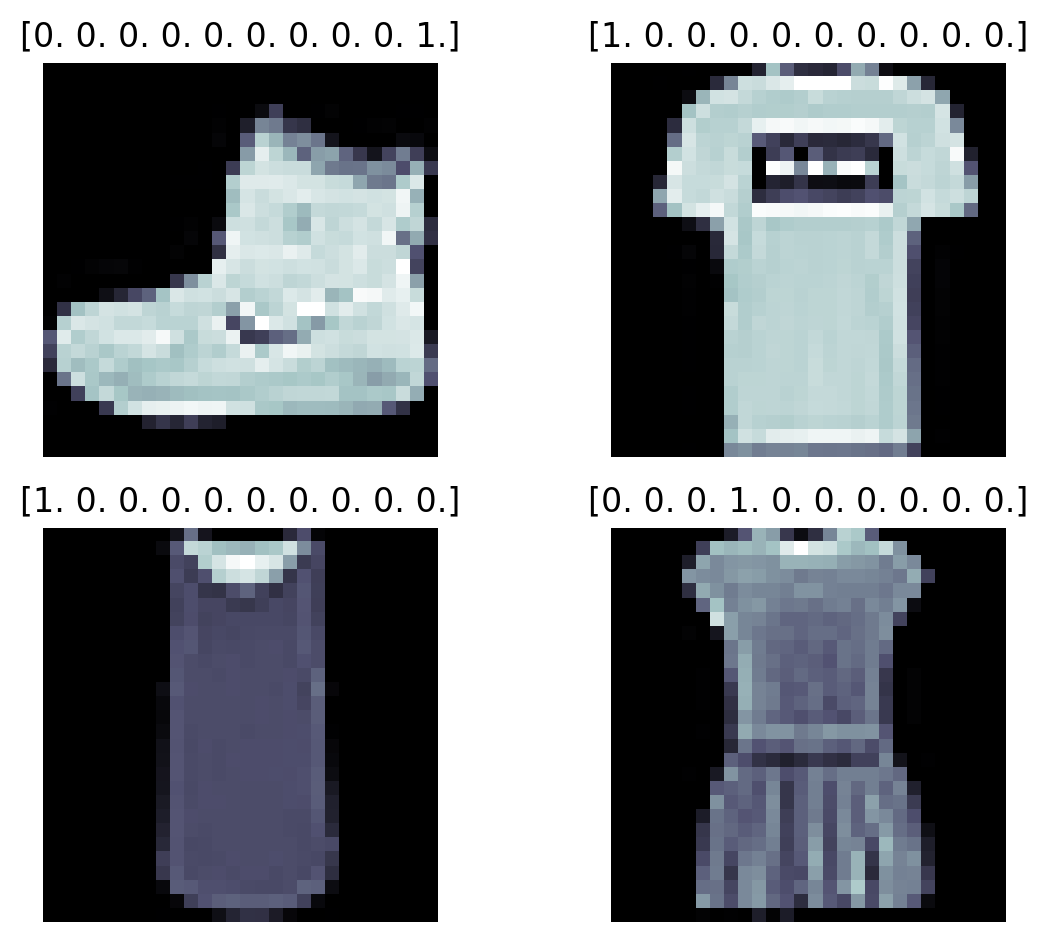

In [6]:
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
# X_train = einops.rearrange(X_train, "s w h -> s (w h)") / 255
# X_test = einops.rearrange(X_test, "s w h -> s (w h)") / 255
X_train = X_train[..., None] / 255
X_test = X_test[..., None] / 255
y_train = jax.nn.one_hot(y_train, 10)
X_train = jnp.array(X_train)
fig, axs = plt.subplots(2, 2)
for i, ax in enumerate(axs.ravel()):
    ax.imshow(X_train[i], cmap="bone")
    ax.set_title(y_train[i])
    ax.axis("off")
plt.tight_layout()

## Train

In [7]:
X_eval = X_test[:5_000]
y_eval = y_test[:5_000]

def callbackfn(bel_update, bel_pred, y, x, agent):
    """
    Compute test accuracy at every timestep
    """
    yhat = agent.link_fn(bel_pred.mean, x)
    acc = y.argmax() == yhat.argmax()
    return acc

In [8]:
class CNN(nn.Module):
    num_arms: int = 10

    @nn.compact
    def __call__(self, x):
        x = x if len(x.shape) > 3 else x[None, :]
        x = nn.Conv(features=6, kernel_size=(5, 5))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = nn.Conv(features=16, kernel_size=(5, 5), padding="VALID")(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding="VALID")
        x = x.reshape((x.shape[0], -1))  # Flatten
        x = nn.Dense(features=120)(x)
        x = nn.relu(x)
        x = nn.Dense(features=84)(x)
        x = nn.relu(x)
        # x = nn.Dense(20, name="last_layer")(x)
        # x = nn.relu(x)
        x = nn.Dense(10, name="last_layer")(x)
        # x = x - jax.nn.logsumexp(x)
        return x.squeeze()

model = CNN()

## Revised version

In [9]:
%%time
key = jax.random.PRNGKey(314)
model = CNN()
agent = lofir.MultinomialFilter(
    model.apply,
    dynamics_covariance=0.0,
    rank=10,
    eps=0.1,
)
params = model.init(key, X_train[:100])

bel_init = agent.init_bel(params, cov=1e-4)
cfn = partial(callbackfn, agent=agent)
bel, hist_lofir = agent.scan(bel_init, y_train[:20_000], X_train[:20_000], cfn)
hist_lofir = np.array(hist_lofir) * 1.0
bel = jax.block_until_ready(bel)

CPU times: user 13.5 s, sys: 76.2 ms, total: 13.6 s
Wall time: 13.1 s


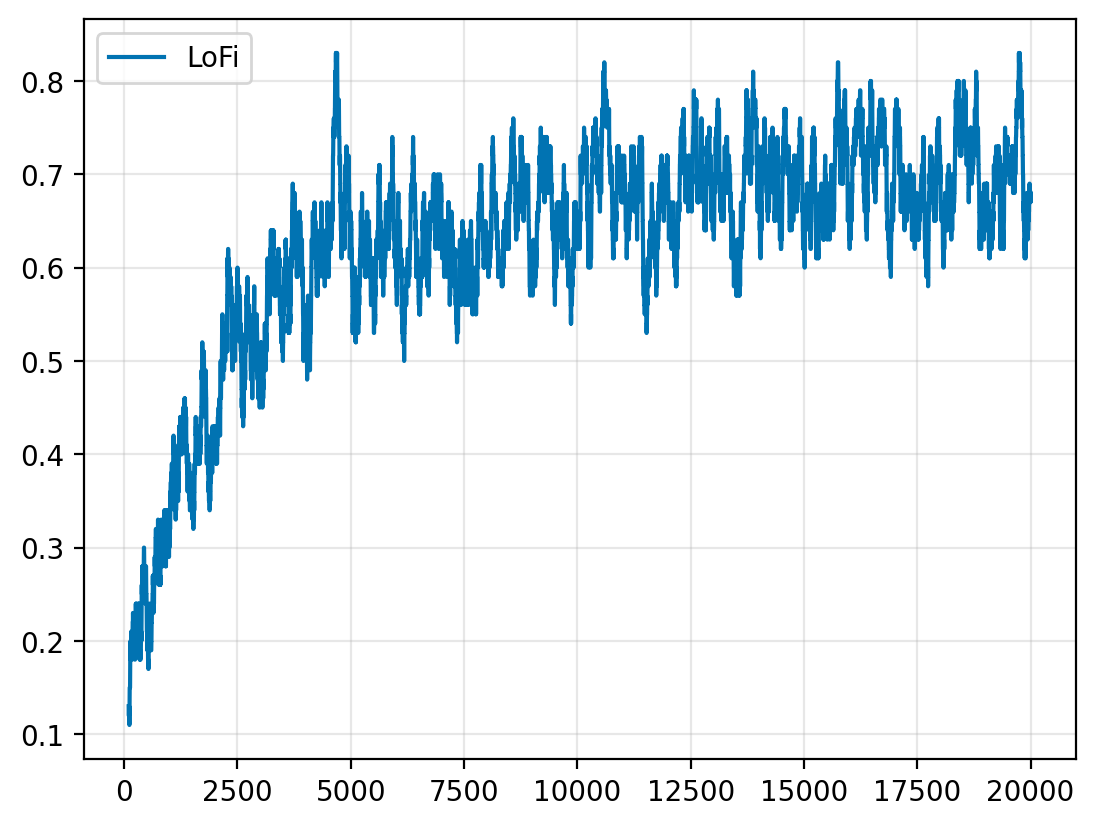

In [10]:
pd.Series(hist_lofir).rolling(100).mean().plot(label="LoFi")
plt.grid(alpha=0.3)
plt.legend()

## Multiple ranks

With constant full-rank inflation

In [22]:
key = jax.random.PRNGKey(3141)

In [23]:
%%time
ranks = [0, 1, 2, 5, 10, 20, 30, 50, 70, 100]
hist_all = {}
times_all = {}
for rank in ranks:
    print(rank, end="\r")
    agent = lofir.MultinomialFilter(
        model.apply,
        dynamics_covariance=0.0,
        rank=rank,
        eps=0.1,
    )
    params = model.init(key, X_train[:100])

    time_init = time()
    bel_init = agent.init_bel(params, cov=1e-4)
    cfn = partial(callbackfn, agent=agent)
    bel, hist_lofir = agent.scan(bel_init, y_train[:20_000], X_train[:20_000], cfn)
    hist_lofir = np.array(hist_lofir) * 1.0
    times_all[rank] = time() - time_init
    hist_all[rank] = hist_lofir

hist_all = pd.DataFrame(hist_all)

CPU times: user 1min 30s, sys: 1.06 s, total: 1min 31s
Wall time: 1min 47s


In [24]:
times_all

{0: 6.612964630126953,
 1: 8.062036752700806,
 2: 7.898763179779053,
 5: 8.128266096115112,
 10: 8.582430362701416,
 20: 9.276673316955566,
 30: 10.397757053375244,
 50: 12.553936958312988,
 70: 15.139024496078491,
 100: 20.991848468780518}

In [25]:
colors = plt.cm.viridis(jnp.linspace(0, 1, len(ranks)))

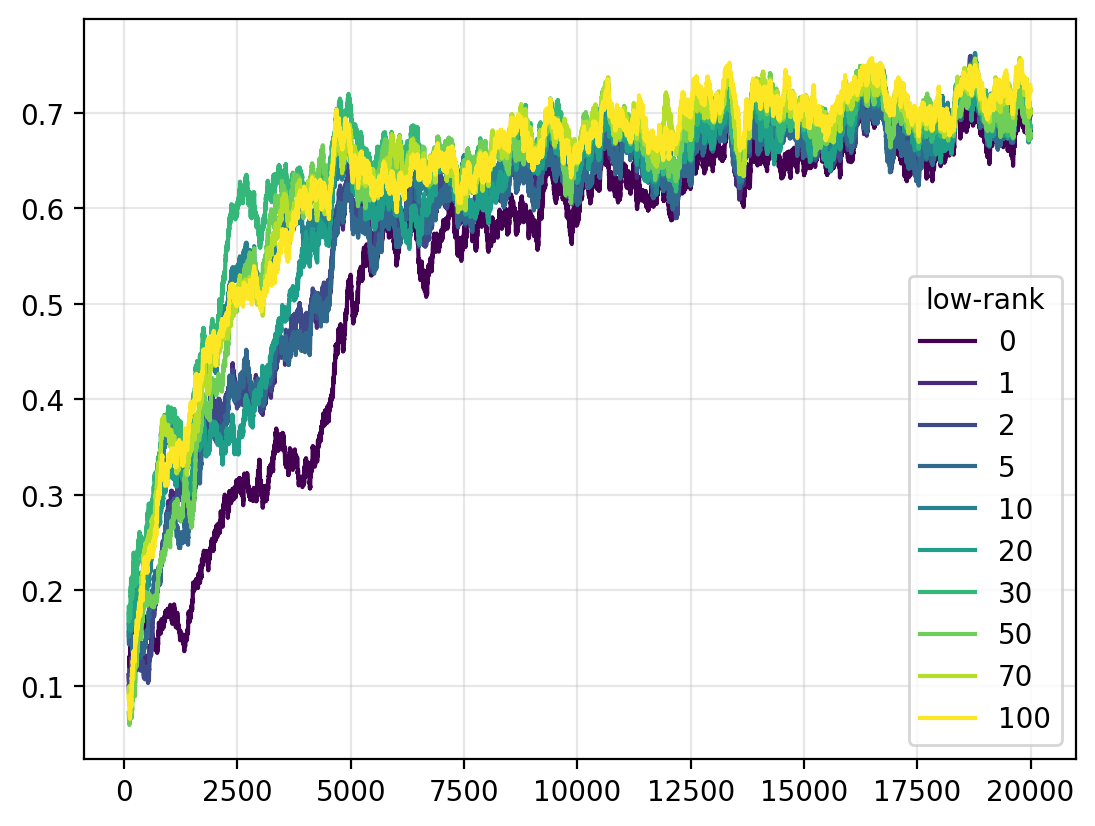

In [26]:
hist_all.ewm(min_periods=100, span=500).mean().plot(color=colors)
plt.legend(title="low-rank")
plt.grid(alpha=0.3)

## The OLLI approach

In [87]:
from jax.flatten_util import ravel_pytree

In [88]:
from rebayes_mini.methods import low_rank_last_layer as olli

In [89]:
agent = olli.LowRankLastLayer(model.apply, 10)
params = model.init(key, X_train[:100])

In [90]:
bel_init = agent.init_bel(params)

In [91]:
jax.tree.map(jnp.shape, bel_init)

OLLIState(mean_last=(850,), loading_last=(850, 850), mean_hidden=(60856,), loading_hidden=(10, 60856))

In [82]:
jax.jacrev(agent.link_fn, argnums=1)(bel_init.mean_hidden, bel_init.mean_last, X_train[0]).shape

(10, 850)